# Monte carlo simulation

In [1]:
import numpy as np 
import polars as pl 
from polars import col 
import matplotlib.pyplot as plt 
import seaborn as sb 


plt.style.use("../matplotlibrc")

In [ ]:
from findec.returns import draw_lognormal_return
from findec.utility import composite_crra_utility
from findec.dataclasses import Preferences

In [ ]:
preferences = Preferences()

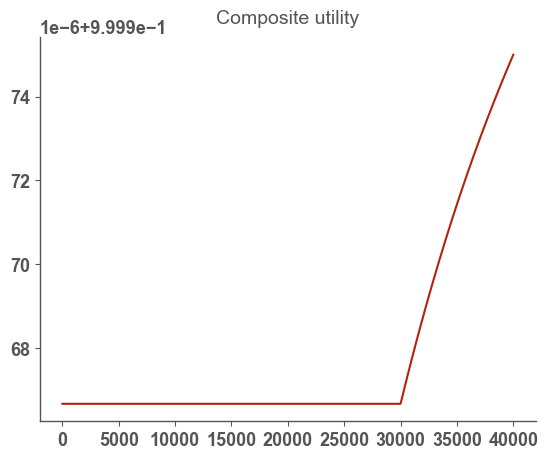

In [4]:
w = np.linspace(0, 40e3, 1000)
u = np.array([composite_crra_utility(wi, pref=preferences) for wi in w])
fig, ax = plt.subplots()
ax.plot(w, u)
ax.set_title("Composite utility");

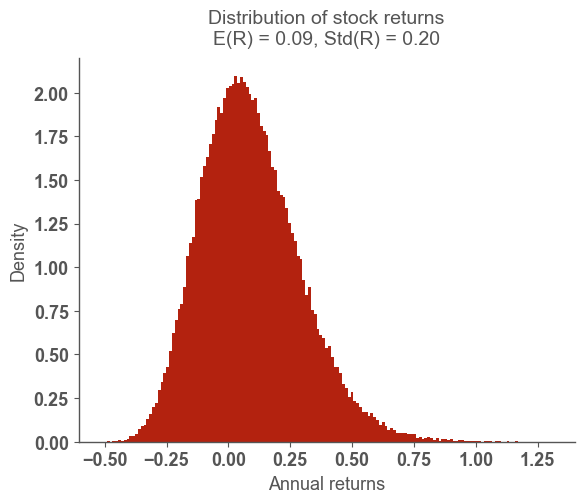

In [7]:
stock_returns = draw_lognormal_return(n_sims=100_000)
fig, ax = plt.subplots()
ax.hist(stock_returns, bins="auto", density=True)
stock_returns_mean = stock_returns.mean()
stock_returns_std = stock_returns.std()
ax.set_xlabel("Annual returns")
ax.set_ylabel("Density")
ax.set_title(
    f"Distribution of stock returns\nE(R) = {stock_returns_mean:.2f}, Std(R) = {stock_returns_std:.2f}"
);

In [379]:
def policy(
    horizon_years: int,
    w: float,
    pref: Preferences,
    return_risk_adjusted_portfolio: float,
    risky_asset: RiskyAsset,
) -> Policy:
    this_gamma = wealth_to_gamma(
        w, subsistence=pref.subsistence, gamma_low=pref.gamma_low, gamma=pref.gamma
    )
    consumption_fraction = optimal_consumption_finite_horizon(
        return_risk_adjusted=return_risk_adjusted_portfolio,
        rate_time_preference=pref.rate_time_preference,
        gamma=this_gamma,
        horizon_years=horizon_years,
    )

    risky_asset_fraction_tax_free = merton_share(risky_asset, this_gamma)
    risky_asset_fraction_taxable = merton_share(risky_asset, this_gamma)

    return Policy(
        consumption_fraction=consumption_fraction,
        risky_asset_fraction_tax_free=risky_asset_fraction_tax_free,
        risky_asset_fraction_taxable=risky_asset_fraction_taxable,
    )

In [ ]:
def simulate_life_path(rng_seed=None):
    if rng_seed is not None:
        np.random.seed(rng_seed)